In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CleanSight (Part 1): Multimodal Analysis and Search of Bus Stop Images
*powered by BigQuery and Gemini*

**bold text**<table align="left">
<td style="text-align: center">
  <a href="https://colab.research.google.com/github/GoogleCloudPlatform/data-to-ai/blob/main/notebooks/part_1_multimodal_analysis_search.ipynb">
    <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
  </a>
</td>
<td style="text-align: center">
  <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fdata-to-ai%2Fmain%2Fnotebooks%2Fpart_1_multimodal_analysis_search.ipynb">
    <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
  </a>
</td>
<td style="text-align: center">
  <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/data-to-ai/main/notebooks/https://colab.research.google.com/github/GoogleCloudPlatform/data-to-ai/blob/main/notebooks/part_1_multimodal_analysis_search.ipynb">
    <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
  </a>
</td>
<td style="text-align: center">
  <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/GoogleCloudPlatform/data-to-ai/blob/main/notebooks/https://colab.research.google.com/github/GoogleCloudPlatform/data-to-ai/blob/main/notebooks/part_1_multimodal_analysis_search.ipynb">
    <img src="https://www.gstatic.com/images/branding/gcpiconscolors/bigquery/v1/32px.svg" alt="BigQuery Studio logo"><br> Open in BigQuery Studio
  </a>
</td>
<td style="text-align: center">
  <a href="https://github.com/GoogleCloudPlatform/data-to-ai/blob/main/notebooks/https://colab.research.google.com/github/GoogleCloudPlatform/data-to-ai/blob/main/notebooks/part_1_multimodal_analysis_search.ipynb">
    <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
  </a>
</table>

## Overview

This notebook showcases the power of multimodal Gemini models and BigQuery vector search for a real-world image analysis use case, as part of a fictional project called **CleanSight**. We'll explore how these integrated capabilities can be used to enable searching and monitoring of physical assets.

Our example focuses on a common challenge for municipalities: operating and maintaining bus stops to ensure the safety of their riders and a good level of service. We'll demonstrate how bus stop operators can monitor their bus stops, be notified of incidents, dispatch the right crew, and track incidents resolution through periodic multimodal analysis with BigQuery and Gemini. We'll also demonstrate how operators can gather further insights with efficient semantic search over their growing database of bus stop reports leveraging BigQuery Vector Search.

This notebook will highlight:

* Using Gemini for multimodal analysis. Gemini will extract relevant details from the bus stop images, and identify issues ranging from litter to broken benches, damaged shelters, or other potential safety hazards.
* Using BigQuery pipelines for orchestration, incident tracking and resolution. BigQuery will process images in Cloud Storage via object table, as well as Gemini output which comprises of both image attributes (structured data) and description (unstructured data), all stored in BigQuery.
* Using Text Embedding model to generate vector embeddings from the textual descriptions to semantically represent the images and enable powerful semantic search using natural language.
* Using BigQuery vector search capabilities for efficient retrieval of images, to help identify semantically similar images. Search results will also be used for retrieval-augmented generation (RAG) to help with decision-making.

While we're using bus stops as our example, the techniques demonstrated here can be readily adapted to other asset monitoring scenarios across various industries.

Let's get started!

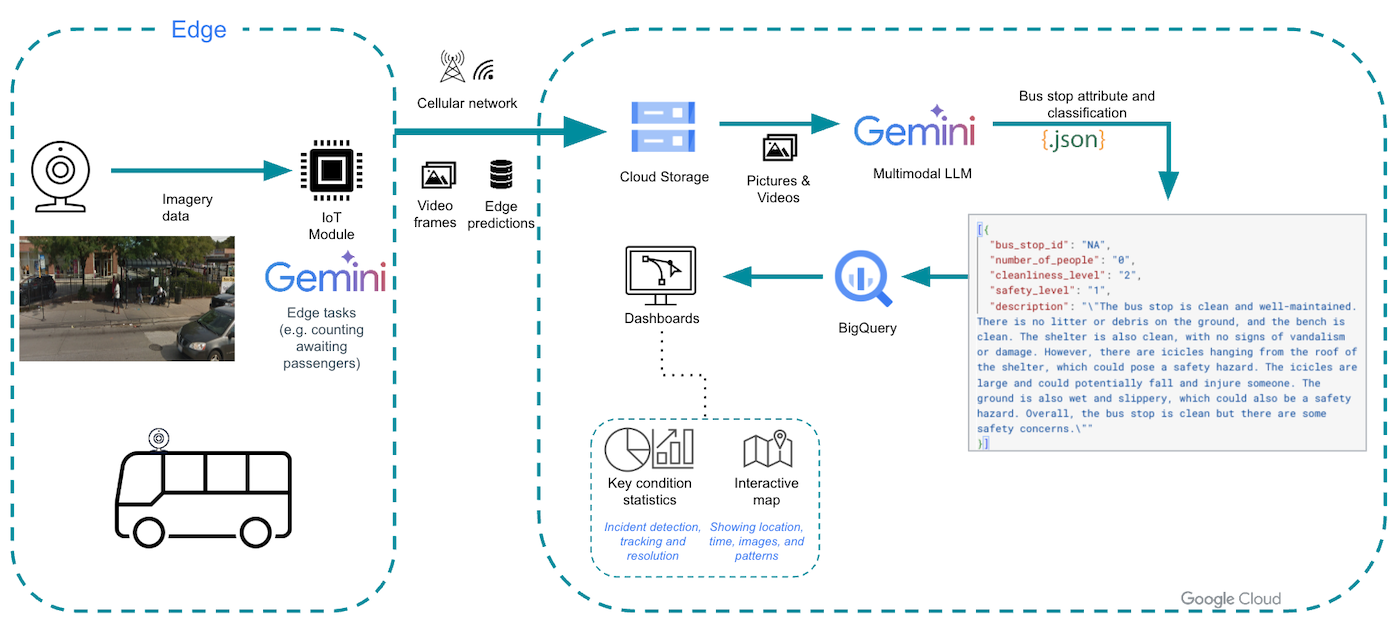

## Getting started

Let's first create some environment variables, including your Google Cloud project ID and the region to deploy resources into:

In [ ]:
PROJECT_ID = "your project ID here" # @param {type:"string"}
REGION = "us-central1" # @param {type:"string"}

BUCKET_NAME = f"{PROJECT_ID}-multimodal"  # Bucket created in subsequent step

### Enable necessary APIs

In [ ]:
!gcloud services enable --project {PROJECT_ID} \
  bigqueryconnection.googleapis.com \
  bigquerystorage.googleapis.com \
  aiplatform.googleapis.com

### Install packages

In [ ]:
%pip install --upgrade --user --quiet \
    google-cloud-aiplatform \
    google-cloud-bigquery

### Import libraries

In [ ]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
from IPython.display import HTML

In [ ]:
# initialize bigquery client
client = bigquery.Client()

# set pandas styling options
# Don't truncate strings in BigQuery query results
pd.set_option('display.max_colwidth', None)

### Define utility functions

We will use the following utility functions, in particular `upload_batch`, to copy images into a given Cloud Storage bucket with specific metadata such as bus stop id and the batch number. This is to simulate the real-world scenario of a transit monitoring solution uploading newly captured bus stop images (tagged with the bus stop ID) and in batches over time e.g. daily.

In [ ]:
import re
from typing import List, Dict, Union
from google.cloud import storage

def parse_gcs_uri(uri: str) -> tuple[str, str]:
    """
    Parse Cloud Storage URI of the form gs://bucket or gs://bucket/path/to/file
    """
    uri = uri.rstrip('/')
    match = re.match(r'gs://([^/]+)(?:/(.*))?', uri)
    if not match:
        raise ValueError(f"Invalid GCS URI format: {uri}")
    bucket_name, path = match.groups()
    return bucket_name, path or ''


def upload_batch(
    batch: List[Dict[str, str]],
    source: str,
    target: str,
    batch_number: Union[int, str]
):
    """
    Copy images from source Cloud Storage location to target with metadata.
    """
    client = storage.Client()

    source_bucket_name, source_prefix = parse_gcs_uri(source)
    target_bucket_name, target_prefix = parse_gcs_uri(target)

    source_bucket = client.bucket(source_bucket_name)
    target_bucket = client.bucket(target_bucket_name)

    count = 0
    for item in batch:
        try:
            source_path = (
                f"{source_prefix}/{item['path']}" if source_prefix
                else item['path']
            )
            target_path = (
                f"{target_prefix}/{item['path']}" if target_prefix
                else item['path']
            )

            # Get source blob
            source_blob = source_bucket.blob(source_path)
            if not source_blob.exists():
                raise FileNotFoundError(f"Source file {source_path} not found")

            # Download the image bytes
            image_bytes = source_blob.download_as_bytes()

            # Prepare target blob with metadata
            target_blob = target_bucket.blob(target_path)
            target_blob.metadata = {
                "batch_number": f"batch-{batch_number}",
                **{k: str(v) for k, v in item.items() if k != "path"}
            }

            # Upload bytes
            target_blob.upload_from_string(
                image_bytes,
                content_type=source_blob.content_type
            )
            count += 1
            print(f"({count}/{len(batch)}) Uploaded: {item['path']}")

        except Exception as e:
            print("Error processing {item['path']}: {str(e)}")


Let's also define some styling functions to help display dataframes with embedded images.

In [ ]:
# Generate HTML img tag from signed url
def preview_image(uri):
  if pd.notna(uri):
    return f'<img src="{uri}" style="width:300px; height:auto; transition: transform 0.25s ease; border: 1px solid black;" onmouseover="this.style.transform=\'scale(2.5)\';" onmouseout="this.style.transform=\'scale(1.0)\';">'
  else:
    return None

# Highlight rows where resolved is False in red
def highlight_unresolved(row):
    if not row['resolved']:
        return ['background-color: #FFCCCC'] * len(row)
    else:
        return ['background-color: #90EE90'] * len(row)

## Import images dataset

Let's create a Cloud Storage bucket to hold the source images

In [ ]:
from google.cloud import storage
from google.api_core import exceptions
storage_client = storage.Client(project=PROJECT_ID)

try:
    bucket = storage_client.create_bucket(BUCKET_NAME, location=REGION)
    print(f"Bucket {BUCKET_NAME} created")
except exceptions.Conflict:
    # Bucket already exists - return the existing bucket
    bucket = storage_client.bucket(BUCKET_NAME)
    print(f"Bucket {BUCKET_NAME} already exists")
except Exception as e:
    print(f"Error creating bucket {BUCKET_NAME}: {e}")

We'll use two separate paths in the newly created bucket:
- `sources` folder to contain all the source images which you will import in the next step.
- `target` folder to contain the images to be processed as you progress in the notebook. This is to simulate images being uploaded in batches over time (e.g. at the end of each day). You will later create and use a BigQuery object table with this source Cloud Storage path.

In [ ]:
SOURCE_PATH = f"gs://{BUCKET_NAME}/sources"
TARGET_PATH = f"gs://{BUCKET_NAME}/target"

Copy the sample images to your bucket:

In [ ]:
!gcloud storage cp "gs://data-to-ai-01-multimodal/sources/*" {SOURCE_PATH}

## Set up BigQuery resources

### Create Cloud Resource Connection

Create a Cloud Resource connection:

In [ ]:
!bq mk \
--connection \
--location={REGION} \
--project_id={PROJECT_ID} \
--connection_type=CLOUD_RESOURCE \
multimodal

### Grant necessary IAM permissions

Retrieve the connection service account ID

In [ ]:
!bq show --connection {PROJECT_ID}.{REGION}.multimodal

Copy the service account ID in the following parameter:

In [ ]:
# Copy the value of `serviceAccountId` field in last cell's output
CONNECTION_SA_ID = "<replace with service account from the output>" # @param {type:"string"}

Grant the connection service account Vertex AI User role:

In [ ]:
!gcloud projects add-iam-policy-binding {PROJECT_ID} \
  --member='serviceAccount:{CONNECTION_SA_ID}' \
  --role='roles/aiplatform.user' --condition=None \
  --no-user-output-enabled

Grant the connection service account Cloud Storage Object viewer role on the bucket

In [ ]:
!gcloud storage buckets add-iam-policy-binding 'gs://{BUCKET_NAME}' \
    --member='serviceAccount:{CONNECTION_SA_ID}' \
    --role=roles/storage.objectViewer


### Create BigQuery dataset and tables

Create your BigQuery dataset

In [ ]:
!bq mk --location={REGION} --dataset {PROJECT_ID}:multimodal

Create the objects table connected to the Cloud Storage bucket:

In [ ]:
sql = f"""
CREATE OR REPLACE EXTERNAL TABLE `multimodal.objects`
WITH CONNECTION `{REGION}.multimodal`
OPTIONS(
  object_metadata = 'SIMPLE',
  uris = ['{TARGET_PATH}/*']
)
"""
query_job = client.query(sql)
query_job.result() # Wait for the job to complete.

Create the BigQuery tables that we'll use in the demo:

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE `multimodal.image_reports` (
  report_id STRING,
  uri STRING,
  updated TIMESTAMP,
  bus_stop_id STRING,
  number_of_people INT64,
  cleanliness_level INT64,
  safety_level INT64,
  description STRING
);

CREATE OR REPLACE TABLE `multimodal.incidents` (
  incident_id STRING NOT NULL,
  bus_stop_id STRING NOT NULL,
  resolved BOOL NOT NULL,
  open_report_id STRING,
  resolve_report_id STRING
);

CREATE OR REPLACE TABLE `multimodal.object_watermark` (
  process_time TIMESTAMP
);
INSERT INTO `multimodal.object_watermark` (SELECT TIMESTAMP('1970-01-01'));

CREATE OR REPLACE TABLE `multimodal.report_watermark` (
  process_time TIMESTAMP
);
INSERT INTO `multimodal.report_watermark` (SELECT TIMESTAMP('1970-01-01'));

CREATE OR REPLACE FUNCTION `multimodal.clean_generate_text_json_response`(input STRING) RETURNS STRING AS
(
  REGEXP_EXTRACT(input, '(?ms)^\\s*`*(?:json)?\\s*({.*})\\s*$')
);

### Create remote models for Gemini

Now create a remote model which you'll use to analyze the pictures using Gemini 1.5 Flash:

In [ ]:
sql = f"""
CREATE OR REPLACE MODEL `multimodal.gemini_flash_model`
REMOTE WITH CONNECTION `{REGION}.multimodal`
OPTIONS ( endpoint = 'gemini-2.0-flash-lite-001' )
"""
query_job = client.query(sql)

Let's create a remote model to use Embedding Vertex AI endpoint to later generate vector embeddings over the textual description

In [ ]:
sql = f"""
CREATE OR REPLACE MODEL `multimodal.text_embedding_model`
REMOTE WITH CONNECTION `{REGION}.multimodal`
OPTIONS ( ENDPOINT = 'text-embedding-005' )
"""
query_job = client.query(sql)

# Multimodal analysis with Gemini

## Batch 1: Initial Incident Detection

Let's now look at the first batch of pictures. We specify the pictures' filenames as well as the corresponding bus stop IDs:

In [ ]:
batch_1 = [
    {"path": "QD-01.jpg", "stop_id": "QD"},
    {"path": "NA-01.jpg", "stop_id": "NA"},
    {"path": "QB-01.jpg", "stop_id": "QB"},
    {"path": "PA-02.jpg", "stop_id": "PA"},
    {"path": "RD-02-dead-leaves.jpg", "stop_id": "RD"},
    {"path": "PC-01.jpg", "stop_id": "PC"},
    {"path": "NC-02.jpg", "stop_id": "NC"},
    {"path": "MD-02.jpg", "stop_id": "MD"},
    {"path": "PB-01.jpg", "stop_id": "PB"},
    {"path": "ND-02-damaged.jpg", "stop_id": "ND"},
    {"path": "QA-02-dirty.jpg", "stop_id": "QA"},
    {"path": "SD-03-dirty-damaged.jpg", "stop_id": "SD"},
    {"path": "MC-02-dirty-damaged.jpg", "stop_id": "MC"},
    {"path": "MA-01.jpg", "stop_id": "MA"},
    {"path": "RC-02-crazy1.jpg", "stop_id": "RC"},
    {"path": "SC-02-broken-glass.jpg", "stop_id": "SC"},
    {"path": "UB-01.jpg", "stop_id": "UB"},
]

Upload the pictures to the bucket - the bus stop IDs are also attached to the files that land in the bucket:

In [ ]:
upload_batch(
    batch=batch_1,
    source=SOURCE_PATH,
    target=TARGET_PATH,
    batch_number=1
)

Let's see the contents of the object table that is linked to the bucket. You see the list of pictures as well as the bus stop IDs, which are stored as object metadata:

In [ ]:
%%bigquery objects_df
SELECT * FROM `multimodal.objects`
ORDER BY updated;

In [ ]:
objects_df[['uri', 'metadata']]

### Preview images

Let's preview the images in this first batch. We'll use the corresponding Cloud Storage authenticated urls, then render them in the dataframe table. Note only users who are granted access to view the bucket objects, can access these images.

In [ ]:
%%bigquery batch1_df
SELECT
  uri, updated,
  CONCAT("https://storage.mtls.cloud.google.com/", SPLIT(uri, "gs://")[OFFSET(1)]) AS url,
  metadata,
FROM `multimodal.objects`, UNNEST(metadata) AS item
WHERE item.name = "batch_number" AND item.value = "batch-1"

In [ ]:
batch1_df['image'] = batch1_df['url'].apply(preview_image)

# Display the DataFrame with embedded images
HTML(batch1_df[['uri', 'image', 'metadata']].to_html(escape=False))

### Analyze images

Now let's look at the first main query of our data pipeline. This purpose of this query is to extract insights from the uploaded pictures. In particular, it prompts a Gemini image model to assess the state of all bus stops. The provided prompt asks Gemini to rate the cleanliness and safety and to provide a detailed description of the scenes:

In [ ]:
reports_creation_query = """
DECLARE last_process_time TIMESTAMP;
DECLARE new_process_time TIMESTAMP;

BEGIN TRANSACTION;
SET last_process_time = (SELECT process_time FROM `multimodal.object_watermark`);
SET new_process_time = CURRENT_TIMESTAMP();

INSERT INTO `multimodal.image_reports`
WITH llm_response AS (
  SELECT
    uri,
    updated,
    ml_generate_text_llm_result,
    metadata,
    multimodal.clean_generate_text_json_response(ml_generate_text_llm_result) as cleaned_result
  FROM
    ML.GENERATE_TEXT(
      MODEL `multimodal.gemini_flash_model`,
      TABLE `multimodal.objects`,
      STRUCT (
    '''
You are a transit supervisor responsible for monitoring bus stops in order to ensure they are safe and clean for everyone. The bus stops are owned and operated by your company CleanSight.
Analyze these pictures of bus stop images and provide accurate details around safety and cleanliness in and around the bus stop. A bus stop is comprised of any combination of the following physical assets: a bench, a sign, a shelter, and/or a trash can. CleanSight is responsible for maintaining all these assets.
Return your answer in valid JSON format (without JSON decorators) with these fields:
* "number_of_people" (Integer): Identify number of people in or around the bus stop.
* "cleanliness_level" (Integer): Rate the general cleanliness of this bus stop. Possible values: 1="dirty and warrants cleaning", 2="clean or mildly clean". The following are examples of cleanliness issues: littering, broken glass, spillage of liquids or oil, ground covered in dead leaves, excessive dirt on benches that would prevent or detract from sitting, unsightly graffiti on the bus stop or surrounding area, disfigured amenities, and anything that would be very unsightly or unreasonably dirty.
* "safety_level" (Integer): Rate the general safety of this bus stop. Possible values: 1="unsafe and warrants attention", 2="safe and doesn't warrant attention". The following are examples of safety issues: broken glass, fallen tree/branches, fire, flooding, electrical hazard, ground covered in dead leaves, dangerous objects, damaged benches/shelters/amenities, slippery ground (e.g. presence of potentially slippery ice on the ground), icicles, low lighting at night, and anything else that could potentially represent a safety hazard for people.
* "description" (String): Provide a detailed textual description of what is in the picture, focusing on cleanliness and safety. This description should explain the cleanliness_level and safety_level scores you provided. This description has a maximum of 200 words. Include any sign of potential vandalism. Do not make things up. Do not make assumptions about the area or the neighborhood where the bus stop is located.
All fields are required.
    ''' AS prompt,
    0.1 AS temperature,
    2048 AS max_output_tokens,
    TRUE AS flatten_json_output)
  )
WHERE content_type = "image/jpeg" AND updated > last_process_time
)
SELECT
  GENERATE_UUID() as report_id,
  uri,
  updated,
  (SELECT value FROM UNNEST(metadata) WHERE name = 'stop_id') AS bus_stop_id,
  CAST (JSON_VALUE(cleaned_result, '$.number_of_people') AS INT64) AS number_of_people,
  CAST (JSON_VALUE(cleaned_result, '$.cleanliness_level') AS INT64) AS cleanliness_level,
  CAST (JSON_VALUE(cleaned_result, '$.safety_level') AS INT64) AS safety_level,
  JSON_VALUE(cleaned_result, '$.description') AS description
FROM llm_response;

-- Update the process time watermark
UPDATE `multimodal.object_watermark`
SET process_time = new_process_time
WHERE TRUE;

COMMIT TRANSACTION;
"""

Let's run the query:

In [ ]:
query_job = client.query(reports_creation_query)
query_job.result()  # Wait for the job to complete.

Now let's look at the results in the reports table:

In [ ]:
%%bigquery
SELECT * FROM `multimodal.image_reports`;

In this table you can see:
* The list of pictures that were just uploaded and the corresponding stop IDs.
* The cleanliness and safety ratings that Gemini provided.
* Number of people detected in the picture
* Textual descriptions of what Gemini could see in the pictures.

### Detect and visualize incidents

Now let's look at the second query of our data pipeline.

This query parses the results from the reports and creates incidents as needed. If it sees that a bus stop was given low cleanliness or safety ratings, it will create a new incident in the `incidents` table with all the details relating to that situation. If, however, it finds high ratings for a bus stop that had previously been flagged, it will close the prior incident for that bus stop:

In [ ]:
incidents_update_query = """
DECLARE last_process_time TIMESTAMP;
DECLARE new_process_time TIMESTAMP;

BEGIN TRANSACTION;
SET last_process_time = (SELECT process_time FROM `multimodal.report_watermark`);
SET new_process_time = CURRENT_TIMESTAMP();

-- Main MERGE statement to update or insert incidents based on new reports
MERGE `multimodal.incidents` AS target
USING (
  -- CTE to get the latest report for each bus stop
  WITH latest_reports AS (
    SELECT
      *,
      -- Assign row numbers to reports for each bus stop, ordered by update time descending
      ROW_NUMBER() OVER (PARTITION BY bus_stop_id ORDER BY updated DESC) AS rn
    FROM `multimodal.image_reports`
    WHERE updated > last_process_time
  )
  -- Main subquery to prepare data for MERGE operation
  SELECT
    lr.bus_stop_id,
    -- Determine if an incident should be resolved based on cleanliness/safety threshold
    CASE
      WHEN lr.cleanliness_level >= 2 AND lr.safety_level >= 2 THEN TRUE
      ELSE FALSE
    END AS should_resolve,
    i.incident_id,
    lr.report_id,
    i.open_report_id
  FROM latest_reports lr
  -- Left join to find existing open incidents for each bus stop
  LEFT JOIN `multimodal.incidents` i
    ON lr.bus_stop_id = i.bus_stop_id
    AND i.resolved = FALSE
  -- Only consider the most recent report for each bus stop
  WHERE lr.rn = 1
) AS source
ON target.incident_id = source.incident_id

-- Update existing incidents: mark as resolved if cleanliness/safety has improved
WHEN MATCHED AND source.should_resolve THEN
  UPDATE SET
    resolved = TRUE,
    resolve_report_id = source.report_id

-- Insert new incidents: create for stops with low cleanliness/safety and no open incident
WHEN NOT MATCHED AND NOT source.should_resolve THEN
  INSERT (incident_id, bus_stop_id, resolved, open_report_id)
  VALUES (GENERATE_UUID(), source.bus_stop_id, FALSE, source.report_id)

-- Update existing incidents: set open_report_id if it's missing
WHEN MATCHED AND NOT source.should_resolve AND target.open_report_id IS NULL THEN
  UPDATE SET
    open_report_id = source.report_id;

-- Update the process time watermark
UPDATE `multimodal.report_watermark`
SET process_time = new_process_time
WHERE TRUE;

COMMIT TRANSACTION;
"""

Let's run the query:

In [ ]:
query_job = client.query(incidents_update_query)
query_job.result()  # Wait for the job to complete.

Let's now run a query to load and display all the created incidents:

In [ ]:
incidents_list_query = f"""
    WITH relevant_reports AS (
      SELECT
        r.report_id, r.uri,
        CONCAT("https://storage.mtls.cloud.google.com/", SPLIT(uri, "gs://")[OFFSET(1)]) AS url,
        description
      FROM `multimodal.incidents` i
      LEFT JOIN `multimodal.image_reports` r ON i.open_report_id = r.report_id OR i.resolve_report_id = r.report_id
      WHERE r.uri IS NOT NULL
    )
    SELECT
      i.bus_stop_id,
      i.resolved,
      open_r.description AS open_report_description,
      open_r.url AS open_report_image_url,
      resolve_r.description AS resolve_report_description,
      resolve_r.url AS resolve_report_image_url
    FROM
      `multimodal.incidents` i
    LEFT JOIN
      `relevant_reports` open_r ON i.open_report_id = open_r.report_id
    LEFT JOIN
      `relevant_reports` resolve_r ON i.resolve_report_id = resolve_r.report_id
    ORDER BY
      i.resolved ASC,
      i.incident_id;
"""

Let's run the query:

In [ ]:
incidents_df = client.query(incidents_list_query).to_dataframe()
print(f"{len(incidents_df)} incidents founds")

In [ ]:
incidents_df['open_report_image'] = incidents_df['open_report_image_url'].apply(preview_image)
incidents_df['resolve_report_image'] = incidents_df['resolve_report_image_url'].apply(preview_image)

styled_incidents_df = incidents_df[
    ['bus_stop_id', 'resolved',
     'open_report_description', 'open_report_image',
     'resolve_report_description', 'resolve_report_image']].style.apply(highlight_unresolved, axis=1)

# Display the DataFrame with embedded images
HTML(styled_incidents_df.to_html(escape=False))

In the above dashboard, you see that a number of incidents were reported for a variety of issues. The incidents show the pictures of the problematic bus stops as well as the corresponding textual description of the situations.

## Batch 2: Incident Tracking and Resolution

Now let's upload another batch of pictures, presumably taken the following day.

In [ ]:
batch_2 = [
    {"path": "ND-02.jpg", "stop_id": "ND"},
    {"path": "MB-01-ice-snow.jpg", "stop_id": "MB"},
    {"path": "NC-01-dirty.jpg", "stop_id": "NC"},
    {"path": "MA-02.jpg", "stop_id": "MA"},
    {"path": "SC-02.jpg", "stop_id": "SC"},
    {"path": "PB-02.jpg", "stop_id": "PB"},
    {"path": "TA-01-graffitis.jpg", "stop_id": "TA"},
    {"path": "UA-01.jpg", "stop_id": "UA"},
    {"path": "UC-02-dirty.jpg", "stop_id": "UC"},
    {"path": "MC-02.jpg", "stop_id": "MC"},
    {"path": "NA-01-ice-snow.jpg", "stop_id": "NA"},
    {"path": "MA-02-broken-glass.jpg", "stop_id": "MA"},
    {"path": "UC-02.jpg", "stop_id": "UC"},
    {"path": "TC-02.jpg", "stop_id": "TC"},
    {"path": "NB-01.jpg", "stop_id": "NB"},
]

In [ ]:
upload_batch(
    batch=batch_2,
    source=SOURCE_PATH,
    target=TARGET_PATH,
    batch_number=2
)

Create the reports for the newly uploaded pictures. This may take a few minutes to process all the pictures by Gemini, depending on your Vertex AI quotas.

In [ ]:
query_job = client.query(reports_creation_query)
query_job.result()  # Wait for the job to complete.

Now update the incidents based on the new reports:

In [ ]:
query_job = client.query(incidents_update_query)
query_job.result()  # Wait for the job to complete.

See the updated list of incidents:

In [ ]:
incidents_df = client.query(incidents_list_query).to_dataframe()

In [ ]:
sns.countplot(x="resolved", data=incidents_df)

In [ ]:
incidents_df['open_report_image'] = incidents_df['open_report_image_url'].apply(preview_image)
incidents_df['resolve_report_image'] = incidents_df['resolve_report_image_url'].apply(preview_image)

styled_incidents_df = incidents_df[
    ['bus_stop_id', 'resolved',
     'open_report_description', 'open_report_image',
     'resolve_report_description', 'resolve_report_image']].style.apply(highlight_unresolved, axis=1)

# Display the DataFrame with embedded images
HTML(styled_incidents_df.to_html(escape=False))

Notice how incidents are updated in the table, including some incidents closed based on improved safety and cleanliness scores in new images of previously flagged bus stops. As an operator, you can see the before-and-after images and descriptions as captions to illustrate the change.


## Repeat with other batches

### Batch \#3

Upload the third batch.

In [ ]:
batch_3 = [
    {"path": "QA-01.jpg", "stop_id": "QA"},
    {"path": "TD-02.jpg", "stop_id": "TD"},
    {"path": "QD-02.jpg", "stop_id": "QD"},
    {"path": "SB-02.jpg", "stop_id": "SB"},
    {"path": "QD-02-graffitis.jpg", "stop_id": "QD"},
    {"path": "TB-01.jpg", "stop_id": "TB"},
    {"path": "TA-02.jpg", "stop_id": "TA"},
    {"path": "UB-02-ice-snow.jpg", "stop_id": "UB"},
    {"path": "QC-02.jpg", "stop_id": "QC"},
    {"path": "PA-02-dirty.jpg", "stop_id": "PA"},
    {"path": "TD-02-dirty.jpg", "stop_id": "TD"},
    {"path": "RD-02.jpg", "stop_id": "RD"},
    {"path": "NC-01.jpg", "stop_id": "NC"},
]

upload_batch(
    batch=batch_3,
    source=SOURCE_PATH,
    target=TARGET_PATH,
    batch_number=3
)

Create new reports and update the incidents:

In [ ]:
query_job = client.query(reports_creation_query)
query_job.result()  # Wait for the job to complete

query_job = client.query(incidents_update_query)
query_job.result()  # Wait for the job to complete.

Let's look at our updated incidents, see the breakdown between resolved vs unresolved incidents, and display the table:

In [ ]:
incidents_df = client.query(incidents_list_query).to_dataframe()

In [ ]:
sns.countplot(x="resolved", data=incidents_df)

In [ ]:
incidents_df['open_report_image'] = incidents_df['open_report_image_url'].apply(preview_image)
incidents_df['resolve_report_image'] = incidents_df['resolve_report_image_url'].apply(preview_image)

styled_incidents_df = incidents_df[
    ['bus_stop_id', 'resolved',
     'open_report_description', 'open_report_image',
     'resolve_report_description', 'resolve_report_image']].style.apply(highlight_unresolved, axis=1)

# Display the DataFrame with embedded images
HTML(styled_incidents_df.to_html(escape=False))

### Batch \#4

In [ ]:
batch_4 = [
    {"path": "SD-03.jpg", "stop_id": "SD"},
    {"path": "UB-02.jpg", "stop_id": "UB"},
    {"path": "PD-02.jpg", "stop_id": "PD"},
    {"path": "QC-01.jpg", "stop_id": "QC"},
    {"path": "RC-01.jpg", "stop_id": "RC"},
    {"path": "NA-02.jpg", "stop_id": "NA"},
    {"path": "PA-01.jpg", "stop_id": "PA"},
    {"path": "SA-02.jpg", "stop_id": "SA"},
    {"path": "RC-02.jpg", "stop_id": "RC"},
    {"path": "RD-01.jpg", "stop_id": "RD"},
    {"path": "SB-01.jpg", "stop_id": "SB"},
    {"path": "PD-02-broken-glass.jpg", "stop_id": "PD"},
    {"path": "NB-02.jpg", "stop_id": "NB"},
    {"path": "PD-01.jpg", "stop_id": "PD"},
    {"path": "QB-02.jpg", "stop_id": "QB"},
    {"path": "TB-02.jpg", "stop_id": "TB"},
]

upload_batch(
    batch=batch_4,
    source=SOURCE_PATH,
    target=TARGET_PATH,
    batch_number=4
)

In [ ]:
query_job = client.query(reports_creation_query)
query_job.result()  # Wait for the job to complete

query_job = client.query(incidents_update_query)
query_job.result()  # Wait for the job to complete.

incidents_df = client.query(incidents_list_query).to_dataframe()
sns.countplot(x="resolved", data=incidents_df)

# Semantic similarity search

### Generate vector embeddings

Let's generate embeddings for all reports, specifically using the textual description field, so we can do semantic search

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE `multimodal.image_reports_vector_db` AS (
SELECT
  report_id, uri, bus_stop_id, content as description,
  cleanliness_level, safety_level,
  ml_generate_embedding_result AS embedding,
  ml_generate_embedding_status AS status
FROM
  ML.GENERATE_EMBEDDING(
    MODEL `multimodal.text_embedding_model`,
    (SELECT * EXCEPT(description), description as content FROM `multimodal.image_reports` WHERE description IS NOT NULL),
    STRUCT('SEMANTIC_SIMILARITY' as task_type)
  )
);

### Build vector index

The next query will most likely fail because the vector index need a certain number of rows to be created. But the following queries will function correctly even if the index is not created, and you can always create the index later to improve the performance of the vector searches. This capability will be demonstrated in the next notebook, titled CleanSight (Part 2).

In [ ]:
%%bigquery
CREATE VECTOR INDEX index_ivf ON `multimodal.image_reports_vector_db`(embedding)
STORING (report_id, uri, bus_stop_id, description, cleanliness_level, safety_level)
OPTIONS (index_type = 'IVF', distance_type = 'COSINE')

### Define search helper function

Let's define this utility function for semantic search. This function generates the text embedding for the test query using the same `text_embedding_model` (and same task type), then runs the `VECTOR_SEARCH` query against the base table of embeddings for the vectors, that is `image_reports_vector_db` table. It then appends the authenticated url link to preview the results including the image.

In [ ]:
def run_semantic_search(query:str):
  escaped_query = query.replace("'", "''").replace("\\", "\\\\")

  search_terms_embeddings_query = f"""
    SELECT
      query.content AS search, distance,
      base.report_id, base.bus_stop_id, base.uri, base.description,
      CONCAT("https://storage.mtls.cloud.google.com/", SPLIT(base.uri, "gs://")[OFFSET(1)]) AS url,
      base.cleanliness_level, base.safety_level
    FROM
      VECTOR_SEARCH(
        TABLE `multimodal.image_reports_vector_db`,
        'embedding',
        (
          SELECT * FROM ML.GENERATE_EMBEDDING(
          MODEL `multimodal.text_embedding_model`,
          (
            SELECT '{escaped_query}' AS content
          ),
          STRUCT('SEMANTIC_SIMILARITY' as task_type))
        ),
        top_k => 3,
        distance_type => 'COSINE'
      )
  """

  return client.query(search_terms_embeddings_query).to_dataframe()

### Search for graffiti

In [ ]:
search_results_df = run_semantic_search('graffiti on or around the bus stop')
search_results_df

search_results_df['image'] = search_results_df['url'].apply(preview_image)

# Display the DataFrame with embedded images
HTML(search_results_df[['bus_stop_id', 'uri', 'distance', 'image', 'description']].to_html(escape=False))

### Search for broken glass

In [ ]:
search_results_df = run_semantic_search('broken glass')
search_results_df

search_results_df['image'] = search_results_df['url'].apply(preview_image)

# Display the DataFrame with embedded images
HTML(search_results_df[['report_id', 'uri', 'distance', 'image', 'description']].to_html(escape=False))

### Search for litter

In [ ]:
search_results_df = run_semantic_search('litter')
search_results_df

search_results_df['image'] = search_results_df['url'].apply(preview_image)

# Display the DataFrame with embedded images
HTML(search_results_df[['bus_stop_id', 'uri', 'distance', 'image', 'description']].to_html(escape=False))

## Hybrid search

Let's do keyword search alongside semantic search to get even more targeted results. The following helper function `run_hybrid_search` accepts a query string (for semantic search) and a keyword string (for full-text search). The keyword search is applied as a pre-filter in the vector search.

In [ ]:
def run_hybrid_search(query:str, keyword:str):
  escaped_query = query.replace("'", "''").replace("\\", "\\\\")
  escaped_keyword = keyword.replace("'", "''").replace("\\", "\\\\")

  search_terms_embeddings_query = f"""
    SELECT
      query.content AS search,
      base.report_id, base.bus_stop_id, base.uri,
      CONCAT("https://storage.mtls.cloud.google.com/", SPLIT(base.uri, "gs://")[OFFSET(1)]) AS url,
      base.description, distance
    FROM
      VECTOR_SEARCH(
        (SELECT * FROM `multimodal.image_reports_vector_db` WHERE SEARCH(description, '`{escaped_keyword}`')),
        'embedding',
        (
          SELECT * FROM ML.GENERATE_EMBEDDING(
          MODEL `multimodal.text_embedding_model`,
          (
            SELECT '{escaped_query}' AS content
          ),
          STRUCT('SEMANTIC_SIMILARITY' as task_type))
        ),
        top_k => 3,
        distance_type => 'COSINE'
      )
  """

  return client.query(search_terms_embeddings_query).to_dataframe()

Let's imagine there were reports of a snake found next to a bus stop. In this case, we need to search for any unsafe bus stop **and** the keyword `snake`.

In [ ]:
search_results_df = run_hybrid_search('unsafe bus stop', 'glass')
search_results_df

search_results_df['image'] = search_results_df['url'].apply(preview_image)

# Display the DataFrame with embedded images
HTML(search_results_df[['bus_stop_id', 'uri', 'distance', 'image', 'description']].to_html(escape=False))

# LLM reasoning with search results (RAG)

In [ ]:
prompt_prefix = f"""\
You are a transit maintenance and safety operator. You are provided with a list of open incident reports of different bus stops.
Reports could be either litter, vandalized property or any other maintenance or safety issue in or around the bus stop that need to be addressed.
Rank the reports based on the urgency of which report or bus stop issue needs to be addressed first.

Rank based on the following details provided with each report:
* "cleanliness_level" (Integer): cleanliness of this bus stop. Possible values: 1="very dirty and warrants urgent cleaning", 2="clean or mildly clean". These are considered cleanliness issues: littering, broken glass, spillage of liquids/oil, ground covered in dead leaves, excessive dirt on benches that would prevent or detract from sitting, unsightly graffitis on the bus stop or surrounding structures, disfigured amenities, and anything that would be very unsightly or unreasonably dirty.
* "safety_level" (Integer): safety of this bus stop. Possible values: 1="unsafe and warrants attention", 2="safe and doesn't warrant attention". These are considered safety issues: broken glass, fallen tree/branches, fire, flooding, electrical hazard, ground covered in dead leaves, dangerous objects, damaged benches/shelters/amenities, slippery ground (e.g. presence of potentially slippery ice on the ground), icicles, low lighting at night, and anything else that could potentially represent a danger for people.
* "description" (String): a detailed textual description of the state of the bus stop.

"""

In [ ]:
search_results_df = run_semantic_search('very unsafe or dirty bus stops')
search_results_df

search_results_df['image'] = search_results_df['url'].apply(preview_image)

# Display the DataFrame with embedded images
HTML(search_results_df[['report_id', 'uri', 'distance', 'image', 'description', 'safety_level', 'cleanliness_level']].to_html(escape=False))

In [ ]:
print(prompt_prefix)

In [ ]:
def run_rag_prompt(prompt_prefix, search_results_df):
  # Format the retrieved results in order to be included as part of the prompt
  prompt_data = ""
  for index, row in search_results_df.iterrows():
      prompt_data += f"report #{index+1} ({row['report_id']}):\n"
      prompt_data += f"uri: {row['uri']}\nsafety_level: {row['safety_level']}\ncleanliness_level: {row['cleanliness_level']}\n"
      prompt_data += f"description: {row['description']}\n\n"

  # Escape newlines before subsequent use in f-strings
  escaped_prompt_prefix = prompt_prefix.replace("\n", "\\n")
  escaped_prompt_data = prompt_data.replace("\n", "\\n")

  llm_query = f"""
  SELECT
    LAX_STRING(ml_generate_text_result.candidates[0].content.parts[0].text) AS response,
    LAX_INT64(ml_generate_text_result.usage_metadata.prompt_token_count) AS input_tokens,
    LAX_INT64(ml_generate_text_result.usage_metadata.candidates_token_count) AS output_tokens,
    LAX_INT64(ml_generate_text_result.usage_metadata.total_token_count) AS total_token_count,
    ml_generate_text_status AS status
  FROM
    ML.GENERATE_TEXT(
      MODEL `multimodal.gemini_flash_model`,
      (
        SELECT CONCAT(
          '''{escaped_prompt_prefix}''',
          "\\nRecent reports:\\n",
          '''{escaped_prompt_data}''',
          "\\nAnswer here:\\n"
        ) AS prompt
      ),
      STRUCT(
        0.2 AS temperature,
        2048 AS max_output_tokens, -- limit response to ~1400 words
        FALSE AS flatten_json_output
      )
    );
  """
  return client.query(llm_query).to_dataframe()

In [ ]:
output = run_rag_prompt(prompt_prefix, search_results_df)
output

Let's render Gemini's response as markdown

In [ ]:
from IPython.display import display, Markdown

# Convert response column to markdown and display
for index, row in output.iterrows():
    display(Markdown(row['response']))


# Summary

In summary, this notebook demonstrated an automated pipeline for detecting incidents (like safety or cleanliness issues) at bus stops using Gemini 1.5 Flash multimodal model. It uses BigQuery to orchestrate the process, leveraging remote models to analyze images stored in Cloud Storage, and storing the analysis results and detected incidents back into BigQuery. The pipeline is designed to incrementally process new images and update incident status as needed. It also includes both semantic and full-text search capabilities for deeper insights and LLM reasoning (RAG).

# Cleanup

In [ ]:
# Delete BigQuery dataset. Uncomment and run the command below if you want to delete the BigQuery set.
# from google.cloud import bigquery
# Do this only if the dataset is created for this demo.
# dataset = f"{PROJECT_ID}.multimodal"
# dataset_object = bigquery.Dataset(dataset)
# client.delete_dataset(dataset_object, delete_contents=True, not_found_ok=True)

